In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint_sequential
from collections import OrderedDict

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def print_to_file(msg):
    print(msg)  # Replace with your logging function if needed

def fast_load_dfs(train_path='train.feather', val_path='val.feather', frac=0.01):
    """
    Load train and validation DataFrames from Feather files,
    and return a fraction of the rows (default 1%).

    Parameters:
        train_path (str): Path to the training DataFrame feather file.
        val_path (str): Path to the validation DataFrame feather file.
        frac (float): Fraction of rows to return from each DataFrame (0 < frac <= 1).
                      Default is 0.01 (i.e. 1% of the data).

    Returns:
        tuple: (train_df, val_df) as sampled Pandas DataFrames.
    """
    train_df = pd.read_feather(train_path)
    val_df = pd.read_feather(val_path)
    print_to_file(f"Loaded train DataFrame from {train_path} and validation DataFrame from {val_path}.")

    if frac < 1.0:
        train_df = train_df.sample(frac=frac, random_state=42)
        val_df = val_df.sample(frac=frac, random_state=42)

    return train_df, val_df

def get_global_vocab_and_cog2idx_from_df(df):
    """
    Extract columns from the DataFrame that correspond to COG or arCOG entries.
    """
    global_vocab = [col for col in df.columns if col.startswith('COG') or col.startswith('arCOG')]
    global_vocab = sorted(global_vocab)
    cog2idx = {cog: idx for idx, cog in enumerate(global_vocab)}
    return global_vocab, cog2idx

# ----------------------------
# Dataset Definitions
# ----------------------------
class GenomeDataset(Dataset):
    def __init__(self, df, global_vocab, cog2idx,
                 false_negative_rate=0.3, false_positive_rate=0.005,
                 count_noise_std=0.0, random_state=None):
        self.df = df.reset_index(drop=True)
        self.global_vocab = global_vocab
        self.cog2idx = cog2idx
        self.vocab_size = len(global_vocab)
        self.false_negative_rate = false_negative_rate
        self.false_positive_rate = false_positive_rate
        self.count_noise_std = count_noise_std
        self.rng = np.random.default_rng(random_state)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        counts = row[self.global_vocab].values.astype(np.float32)
        target = (counts > 0).astype(np.float32)
        
        observed_indices = []
        observed_counts = []
        for cog_idx, present in enumerate(target):
            if present:
                if self.rng.random() < self.false_negative_rate:
                    continue
                original_count = counts[cog_idx]
                noise = 1  # or add noise if desired
                noisy_count = max(original_count * noise, 0.0)
                observed_indices.append(cog_idx)
                observed_counts.append(noisy_count)
        
        # Simulate false positives
        num_false_positives = self.rng.poisson(lam=self.false_positive_rate * self.vocab_size)
        absent_indices = np.where(target == 0)[0]
        if len(absent_indices) > 0 and num_false_positives > 0:
            false_pos = self.rng.choice(absent_indices, size=min(num_false_positives, len(absent_indices)), replace=False)
            for fp in false_pos:
                noisy_count = 1
                observed_indices.append(fp)
                observed_counts.append(noisy_count)
        
        if len(observed_indices) == 0:
            tokens = np.empty((0, 2), dtype=np.float32)
        else:
            tokens = np.stack([np.array(observed_indices, dtype=np.int64),
                               np.array(observed_counts, dtype=np.float32)], axis=-1)
        
        sample = {
            'tokens': tokens,
            'target': target  # Ground truth binary vector (V,)
        }
        return sample

def collate_genomes(batch, pad_idx):
    batch_tokens = [sample['tokens'] for sample in batch]
    targets = [sample['target'] for sample in batch]
    batch_size = len(batch_tokens)
    max_len = max(tokens.shape[0] for tokens in batch_tokens)
    tokens_padded = np.full((batch_size, max_len, 2), fill_value=0, dtype=np.float32)
    mask = np.ones((batch_size, max_len), dtype=bool)
    
    for i, tokens in enumerate(batch_tokens):
        length = tokens.shape[0]
        if length > 0:
            tokens_padded[i, :length, :] = tokens
            mask[i, :length] = False
        if length < max_len:
            tokens_padded[i, length:, 0] = pad_idx
    tokens_padded = torch.tensor(tokens_padded)
    mask = torch.tensor(mask)
    targets = torch.tensor(np.stack(targets, axis=0), dtype=torch.float32)
    return tokens_padded, mask, targets

# ----------------------------
# Model Definitions (SetTransformer)
# ----------------------------
class SAB(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.0):
        super(SAB, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.ln1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
        self.ln2 = nn.LayerNorm(dim)
    
    def forward(self, X, mask=None):
        attn_out, _ = self.mha(X, X, X, key_padding_mask=mask)
        X = self.ln1(X + attn_out)
        ff_out = self.ff(X)
        out = self.ln2(X + ff_out)
        return out

class PMA(nn.Module):
    def __init__(self, dim, num_seeds, num_heads, dropout=0.0):
        super(PMA, self).__init__()
        self.num_seeds = num_seeds
        self.seed = nn.Parameter(torch.randn(num_seeds, dim))
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.ln = nn.LayerNorm(dim)
    
    def forward(self, X, mask=None):
        batch_size = X.shape[1]
        S = self.seed.unsqueeze(1).expand(-1, batch_size, -1)
        pooled, _ = self.mha(S, X, X, key_padding_mask=mask)
        pooled = pooled + S
        pooled = self.ln(pooled)
        return pooled

class GenomeSetTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=4, num_sab=2, dropout=0.1):
        super(GenomeSetTransformer, self).__init__()
        self.vocab_size = vocab_size
        self.pad_idx = vocab_size  # extra token for padding
        self.cog_embedding = nn.Embedding(num_embeddings=vocab_size + 1, embedding_dim=d_model, padding_idx=self.pad_idx)
        self.count_linear = nn.Linear(1, d_model)
        self.sab_blocks = nn.ModuleList([SAB(dim=d_model, num_heads=num_heads, dropout=dropout) for _ in range(num_sab)])
        self.pma = PMA(dim=d_model, num_seeds=1, num_heads=num_heads, dropout=dropout)
        self.decoder = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.ReLU(),
            nn.Linear(d_model, vocab_size)
        )
    
    def forward(self, tokens, mask):
        B, N, _ = tokens.size()
        cog_ids = tokens[:, :, 0].long()
        binary_counts = (tokens[:, :, 1].float() > 0).float().unsqueeze(-1)
        emb_cog = self.cog_embedding(cog_ids)
        emb_count = self.count_linear(binary_counts)
        X = emb_cog + emb_count
        
        local_features = X.mean(dim=1)
        X = X.transpose(0, 1)
        for sab in self.sab_blocks:
            X = sab(X, mask=mask)
        pooled = self.pma(X, mask=mask)
        pooled = pooled.squeeze(0)
        combined = torch.cat([pooled, local_features], dim=1)
        logits = self.decoder(combined)
        probs = torch.sigmoid(logits)
        return probs

# ----------------------------
# Model Definitions (BinaryMLM)
# ----------------------------
class BinaryMLMModel(nn.Module):
    def __init__(self, 
                 vocab_size=3,
                 embed_dim=512, 
                 num_layers=6, 
                 num_heads=8, 
                 dropout=0.1, 
                 max_seq_len=10000):
        super(BinaryMLMModel, self).__init__()
        self.embed_dim = embed_dim
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embed_dim)
        self.dropout = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            dropout=dropout,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.mlm_head = nn.Linear(embed_dim, 2)
        self.init_weights()
        
    def init_weights(self):
        nn.init.xavier_uniform_(self.token_embedding.weight)
        nn.init.xavier_uniform_(self.position_embedding.weight)
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, input_ids, labels=None):
        batch_size, seq_length = input_ids.shape
        positions = torch.arange(0, seq_length, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_length)
        token_embeds = self.token_embedding(input_ids)
        pos_embeds = self.position_embedding(positions)
        x = token_embeds + pos_embeds
        x = self.dropout(x)
        x = x.transpose(0, 1)
        num_layers = len(self.transformer.layers)
        x = checkpoint_sequential(self.transformer.layers, num_layers, x)
        x = x.transpose(0, 1)
        logits = self.mlm_head(x)
        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits.view(-1, 2), labels.view(-1), ignore_index=-100)
        return logits, loss



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load DataFrames and vocabulary
train_df, val_df = fast_load_dfs('COG_train1.feather', 'COG_val1.feather', frac=0.01)
global_vocab, cog2idx = get_global_vocab_and_cog2idx_from_df(train_df)

# Load pretrained SetTransformer
set_transformer = GenomeSetTransformer(vocab_size=len(global_vocab), d_model=256,
                                             num_heads=4, num_sab=2, dropout=0.1)

# Load SetTransformer weights using map_location=device
set_transformer_state = torch.load('COG_high3_256_4_8_BCE_40.pth', map_location=device)
set_transformer.load_state_dict(set_transformer_state)

# Load pretrained BinaryMLM
binary_mlm = BinaryMLMModel(vocab_size=3, embed_dim=512, num_layers=6,
                                num_heads=8, dropout=0.1, max_seq_len=len(global_vocab))
# Load BinaryMLM weights similarly
binary_mlm_state = torch.load('binaryMLM_checkpoint.pth', map_location=device)
new_state_dict = OrderedDict()
for k, v in binary_mlm_state.items():
    name = k[7:] if k.startswith("module.") else k
    new_state_dict[name] = v
binary_mlm.load_state_dict(new_state_dict)

Loaded train DataFrame from COG_train1.feather and validation DataFrame from COG_val1.feather.


/Users/ssolo/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


<All keys matched successfully>

In [4]:
# For the SetTransformer, extract from its cog_embedding (exclude the pad token at index vocab_size)
vocab_size = set_transformer.vocab_size  # This should be defined in your model (e.g., the original number of COGs)
set_transformer_embeddings = set_transformer.cog_embedding.weight[:vocab_size].detach().cpu().numpy()
print(f"SetTransformer embeddings shape: {set_transformer_embeddings.shape}")

# For the binary MLM, check if it has a cog_embedding attribute; if not, use a placeholder.
if hasattr(binary_mlm, 'cog_embedding'):
    binary_mlm_embeddings = binary_mlm.cog_embedding.weight[:vocab_size].detach().cpu().numpy()
    print(f"BinaryMLM embeddings shape: {binary_mlm_embeddings.shape}")
else:
    print("BinaryMLM does not have a 'cog_embedding' attribute; using SetTransformer embeddings as a placeholder.")
    binary_mlm_embeddings = set_transformer_embeddings

SetTransformer embeddings shape: (4789, 256)
BinaryMLM does not have a 'cog_embedding' attribute; using SetTransformer embeddings as a placeholder.


In [16]:
import requests
import pandas as pd
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Download and Parse the COG Definitions File
# ---------------------------

# URL for the COG definitions file
url = "https://ftp.ncbi.nih.gov/pub/COG/COG2020/data/cog-20.def.tab"
response = requests.get(url)
if response.status_code == 200:
    with open("cog-20.def.tab", "wb") as f:
        f.write(response.content)
    print("Downloaded cog-20.def.tab successfully.")
else:
    raise Exception(f"Error downloading file: HTTP {response.status_code}")

In [24]:
# Read the tab-delimited file (it has no header)
df_cog = pd.read_csv("cog-20.def.tab", sep="\t", header=None, engine="python", encoding="latin1")
# Assign column names; based on the provided sample:
df_cog = pd.read_csv("cog-20.def.tab", sep="\t", header=None, engine="python", encoding="latin1")
df_cog.columns = ["COG_ID", "Category", "Description", "Gene_Symbol", "Function", "Extra", "PDB_ID"]
# ---------------------------
# 2. Map to Canonical Metacategories
# ---------------------------
# Define canonical mapping for each letter.
meta_map = {
    "S": "Poorly Characterized", "R": "Poorly Characterized",
    "Q": "Metabolism", "P": "Metabolism", "I": "Metabolism",
    "H": "Metabolism", "F": "Metabolism", "E": "Metabolism",
    "G": "Metabolism", "C": "Metabolism",
    "O": "Cellular Processes & Signaling", "U": "Cellular Processes & Signaling", "W": "Cellular Processes & Signaling",
    "N": "Cellular Processes & Signaling", "M": "Cellular Processes & Signaling", "T": "Cellular Processes & Signaling",
    "V": "Cellular Processes & Signaling", "D": "Cellular Processes & Signaling",
    "B": "Information Storage & Processing", "L": "Information Storage & Processing", "K": "Information Storage & Processing",
    "A": "Information Storage & Processing", "J": "Information Storage & Processing"
}

def assign_metacategory(cat_str, meta_map):
    """
    For a given category string (which may contain multiple letters),
    assign a canonical metacategory using majority rule.
    """
    counts = {}
    for letter in str(cat_str):
        if letter in meta_map:
            mc = meta_map[letter]
            counts[mc] = counts.get(mc, 0) + 1
    if counts:
        return max(counts, key=counts.get)
    else:
        return None

# Process all rows: keep original Category and compute Meta_Category.
functional_df = df_cog[["COG_ID", "Category"]].copy()
functional_df["Meta_Category"] = functional_df["Category"].apply(lambda x: assign_metacategory(x, meta_map))
functional_df = functional_df.dropna(subset=["Meta_Category"])
functional_df = functional_df.sort_values("COG_ID").reset_index(drop=True)
functional_df["COG_Index"] = functional_df.index
print("First few rows of functional_df with Meta_Category:")
print(functional_df.head())

First few rows of functional_df with Meta_Category:
    COG_ID Category Meta_Category  COG_Index
0  COG0001        H    Metabolism          0
1  COG0002        E    Metabolism          1
2  COG0003        P    Metabolism          2
3  COG0004        P    Metabolism          3
4  COG0005        F    Metabolism          4


In [25]:
# ---------------------------
# 2. Extract Model Embeddings and Project to 2D with t-SNE
# ---------------------------

# Assuming your preloaded models are named "set_transformer" and "binary_mlm".
# They should have been loaded previously, e.g.:
#    set_transformer = GenomeSetTransformer(...)
#    binary_mlm = BinaryMLMModel(...)

# Assuming your set_transformer is already loaded and has an attribute "cog_embedding"
vocab_size = set_transformer.vocab_size  # This is the number of COG tokens (without the pad token)
# Extract only the COG identity embeddings (ignoring any additional count processing)
cog_identity_embeddings = set_transformer.cog_embedding.weight[:vocab_size].detach().cpu().numpy()
print("COG identity embeddings shape:", cog_identity_embeddings.shape)

# For the BinaryMLM, if a similar embedding layer exists:
binary_mlm_embeddings = binary_mlm.position_embedding.weight[:vocab_size].detach().cpu().numpy()
print("COG identity embeddings shape:", binary_mlm_embeddings.shape)

# Use t-SNE to reduce embeddings to 2D
tsne_set = TSNE(n_components=2, random_state=4, perplexity=50, learning_rate=100, max_iter=5000)
set_embeds_2d = tsne_set.fit_transform(cog_identity_embeddings)

tsne_bin = TSNE(n_components=2, random_state=4, perplexity=50, learning_rate=100, max_iter=5000)
bin_embeds_2d = tsne_bin.fit_transform(binary_mlm_embeddings)



COG identity embeddings shape: (4789, 256)
COG identity embeddings shape: (4789, 512)


Color mapping (per metacategory):
Metabolism: {'C': (np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.8)), 'CE': (np.float64(0.006366782006920414), np.float64(0.001983852364475202), np.float64(0.9986620530565167), np.float64(0.8)), 'CHR': (np.float64(0.014855824682814302), np.float64(0.004628988850442138), np.float64(0.996878123798539), np.float64(0.8)), 'CI': (np.float64(0.023344867358708186), np.float64(0.0072741253364090736), np.float64(0.9950941945405614), np.float64(0.8)), 'CIR': (np.float64(0.03183391003460207), np.float64(0.00991926182237601), np.float64(0.9933102652825836), np.float64(0.8)), 'CJ': (np.float64(0.04032295271049596), np.float64(0.012564398308342946), np.float64(0.9915263360246059), np.float64(0.8)), 'CO': (np.float64(0.04881199538638985), np.float64(0.015209534794309882), np.float64(0.9897424067666282), np.float64(0.8)), 'CP': (np.float64(0.05730103806228373), np.float64(0.017854671280276818), np.float64(0.9879584775086505), np.float64(0.8)), 'CPO':

/var/folders/84/gnp0bk0116d_1887rwyn_ml00000gn/T/ipykernel_74182/3812383514.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["color"] = group["Category"].map(lambda cat: color_mapping[meta].get(cat, "#000000"))
/var/folders/84/gnp0bk0116d_1887rwyn_ml00000gn/T/ipykernel_74182/3812383514.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["color"] = group["Category"].map(lambda cat: color_mapping[meta].get(cat, "#000000"))
/var/folders/84/gnp0bk0116d_1887rwyn_ml00000gn/T/ipykernel_74182/38123

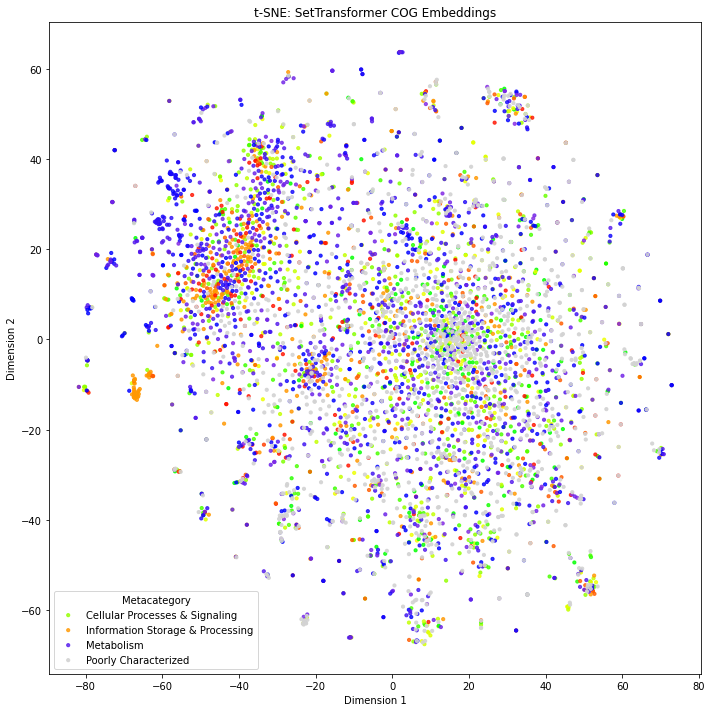

/var/folders/84/gnp0bk0116d_1887rwyn_ml00000gn/T/ipykernel_74182/3812383514.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["color"] = group["Category"].map(lambda cat: color_mapping[meta].get(cat, "#000000"))
/var/folders/84/gnp0bk0116d_1887rwyn_ml00000gn/T/ipykernel_74182/3812383514.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["color"] = group["Category"].map(lambda cat: color_mapping[meta].get(cat, "#000000"))
/var/folders/84/gnp0bk0116d_1887rwyn_ml00000gn/T/ipykernel_74182/38123

<Figure size 432x288 with 0 Axes>

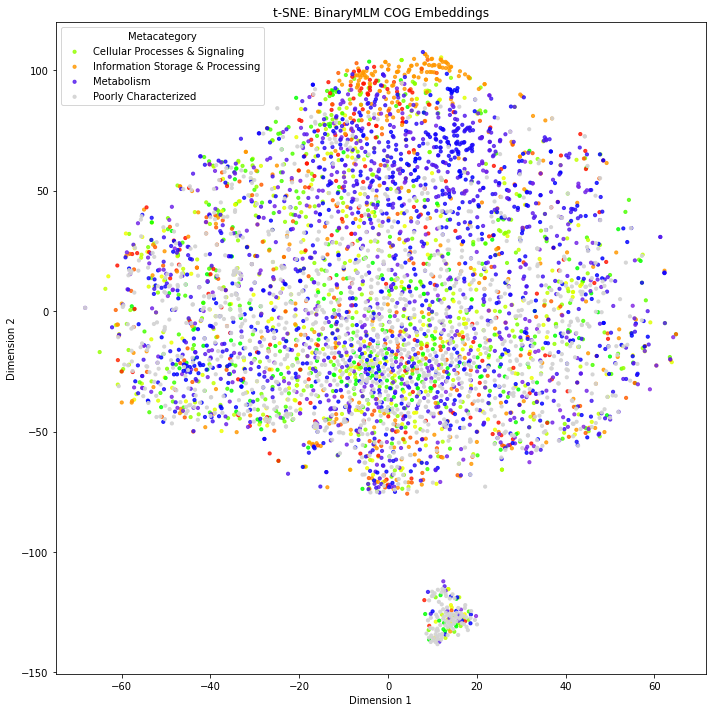

<Figure size 432x288 with 0 Axes>

In [50]:
from matplotlib.colors import LinearSegmentedColormap, to_rgba
# ---------------------------
# 3. Define Custom Color Gradients with Differential Alpha
# ---------------------------
# For each metacategory, specify a start color, an end color, and an alpha.
metacategory_colormaps = {
    "Poorly Characterized": {"start": "#d3d3d3", "end": "#d3d3d3", "alpha": 0.9},  # Light grey to Black
    "Metabolism": {"start": "#0000FF", "end": "#8A2BE2", "alpha": 0.8},               # Blue to Violet
    "Cellular Processes & Signaling": {"start": "#00FF00", "end": "#FFFF00", "alpha": 0.8},  # Green to Yellow
    "Information Storage & Processing": {"start": "#FFA500", "end": "#FF0000", "alpha": 0.8}  # Orange to Red
}

def get_color_palette(meta, num_colors):
    settings = metacategory_colormaps[meta]
    start_rgba = to_rgba(settings["start"], alpha=settings["alpha"])
    end_rgba = to_rgba(settings["end"], alpha=settings["alpha"])
    cmap = LinearSegmentedColormap.from_list(f"{meta}_cmap", [start_rgba, end_rgba])
    if num_colors > 1:
        return [cmap(i/(num_colors-1)) for i in range(num_colors)]
    else:
        return [cmap(0.5)]

# For each metacategory, determine unique original categories and map them to a color from the palette.
meta_categories = {}
for meta in functional_df["Meta_Category"].unique():
    cats = sorted(functional_df[functional_df["Meta_Category"] == meta]["Category"].unique())
    meta_categories[meta] = cats

color_mapping = {}
for meta, cats in meta_categories.items():
    palette = get_color_palette(meta, len(cats))
    color_mapping[meta] = dict(zip(cats, palette))

print("Color mapping (per metacategory):")
for meta, mapping in color_mapping.items():
    print(f"{meta}: {mapping}")

# ---------------------------
# 5. Merge t-SNE Data with Functional Information
# ---------------------------
df_set = pd.DataFrame(set_embeds_2d, columns=["x", "y"])
df_set["COG_Index"] = np.arange(vocab_size)
df_set = df_set.merge(functional_df[["COG_Index", "Category", "Meta_Category"]], on="COG_Index", how="left")

df_bin = pd.DataFrame(bin_embeds_2d, columns=["x", "y"])
df_bin["COG_Index"] = np.arange(vocab_size)
df_bin = df_bin.merge(functional_df[["COG_Index", "Category", "Meta_Category"]], on="COG_Index", how="left")

df_set = df_set.dropna(subset=["Meta_Category"])
df_bin = df_bin.dropna(subset=["Meta_Category"])

# ---------------------------
# 6. Plot t-SNE: Separate Plots with Consistent Colors for Metacategories and Gradient Shades for Each Original Category
# ---------------------------
# For SetTransformer embeddings:
plt.figure(figsize=(10, 10))
for meta in sorted(df_set["Meta_Category"].unique()):
    group = df_set[df_set["Meta_Category"] == meta]
    # Map each point's original Category to its corresponding color from the gradient.
    group["color"] = group["Category"].map(lambda cat: color_mapping[meta].get(cat, "#000000"))
    plt.scatter(group["x"], group["y"], color=group["color"].tolist(), label=meta, s=10)
plt.title("t-SNE: SetTransformer COG Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Metacategory")
plt.tight_layout()
plt.show()
plt.savefig("settransformer_tsne_metacategories_gradient.png", dpi=300)

# For BinaryMLM embeddings:
plt.figure(figsize=(10, 10))
for meta in sorted(df_bin["Meta_Category"].unique()):
    group = df_bin[df_bin["Meta_Category"] == meta]
    group["color"] = group["Category"].map(lambda cat: color_mapping[meta].get(cat, "#000000"))
    plt.scatter(group["x"], group["y"], color=group["color"].tolist(), label=meta, s=10)
plt.title("t-SNE: BinaryMLM COG Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Metacategory")
plt.tight_layout()
plt.show()
plt.savefig("binarymlm_tsne_metacategories_gradient.png", dpi=300)

In [25]:
import numpy as np
print(np.__version__)

2.2.2


In [7]:
train_df

,accession,COG0001,COG0002,COG0003,COG0004,COG0005,COG0006,COG0007,COG0008,COG0009,...,coding_bases,genome_size,gc_percentage,domain,phylum,class,order,family,group,species
78275,GB_GCA_944371685.1,0,0,0,0,0,0,0,1,0,...,980267,1083550,29.197361,d__Bacteria,p__Bacillota_I,c__Bacilli_A,o__RF39,f__UBA660,g__Coprosoma,s__Coprosoma sp944371685
19536,GB_GCA_902794055.1,0,0,1,0,0,1,0,1,1,...,2009902,2279314,52.898171,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Christensenellales,f__CAG-138,g__PeH17,s__PeH17 sp902794055
37954,RS_GCF_017874595.1,1,1,0,1,1,6,3,2,1,...,5466808,6333755,61.650127,d__Bacteria,p__Pseudomonadota,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Sinorhizobium,s__Sinorhizobium kostiense
19409,GB_GCA_028694425.1,0,0,0,0,2,1,0,0,1,...,1897762,2228545,34.361209,d__Bacteria,p__Cyanobacteriota,c__Vampirovibrionia,o__Gastranaerophilales,f__Gastranaerophilaceae,g__CAIPUE01,s__CAIPUE01 sp028694425
41638,RS_GCF_030547185.1,1,1,0,4,1,1,1,3,2,...,2966869,3334149,42.985391,d__Bacteria,p__Pseudomonadota,c__Gammaproteobacteria,o__Pseudomonadales,f__Nitrincolaceae,g__Neptuniibacter,s__Neptuniibacter sp030547185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89756,GB_GCA_900549665.1,0,0,0,1,1,1,0,2,1,...,2238291,2500513,42.524834,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__UBA2882,s__UBA2882 sp900549665
24753,GB_GCA_910576985.1,0,0,0,0,0,0,0,1,1,...,1222087,1379434,29.898266,d__Bacteria,p__Bacillota_I,c__Bacilli_A,o__RF39,f__UBA660,g__MGBC102946,s__MGBC102946 sp910576985
77314,RS_GCF_000160855.1,0,0,0,1,0,2,0,1,1,...,1550698,2020582,36.781287,d__Bacteria,p__Bacillota,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__Lactobacillus helveticus
5046,RS_GCF_002080435.1,0,1,0,2,0,1,2,3,1,...,3815559,4240798,62.463692,d__Bacteria,p__Pseudomonadota,c__Alphaproteobacteria,o__Sphingomonadales,f__Sphingomonadaceae,g__Sphingobium,s__Sphingobium herbicidovorans


In [22]:
df_cog.head()

,COG_ID,Category,Description,Gene_Symbol,Function,Extra,PDB_ID
0,COG0001,H,Glutamate-1-semialdehyde aminotransferase,HemL,Heme biosynthesis,NaN,2CFB
1,COG0002,E,N-acetyl-gamma-glutamylphosphate reductase,ArgC,Arginine biosynthesis,NaN,3DR3
2,COG0003,P,"Anion-transporting ATPase, ArsA/GET3 family",ArsA,NaN,NaN,1F48
3,COG0004,P,Ammonia channel protein AmtB,AmtB,NaN,NaN,1U77
4,COG0005,F,Purine nucleoside phosphorylase,XapA,Purine salvage,NaN,1YQQ
